# Nonlinear Regression



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from torchvision import datasets
from torchvision import transforms

Let's consider:

$$ \mathcal{D} = \{x_i, y_i\}^l_{i=1}, ~x_i \in \mathcal{R}, ~y_i\in \mathcal{R}$$

It is known that:

$$y_i = f(x_i) ~\forall i \in 1 ... l,$$

where the function $f$ belongs to the following parametric family of functions:

$$\mathcal{F} = \{ f: f(x, w) = w_0 + w_1 x + w_2 \sin(x) + w_3 \cos(x), w \in \mathcal{R^4}\}$$

How to approximate $\mathcal{D}$?

Approximating the dataset involves minimizing the following functional:

$$L = \sum_{i=1}^l (f(x_i, w) - y_i)^2 \to \min_w $$

Solition one:

map the original feature space into a new space: $x_i = [1, x_i, sin(x_i), cos(x_i) ]$

In [9]:
np.random.seed(42)
l=200
beta = 2. # noise

x = np.linspace(-10, 10, l)
w = np.array([5., 3., 9., 7.])
y = w[0] + w[1]*x + w[2]*np.sin(x) + w[3]*np.cos(x) + beta*np.random.randn(l)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=50)

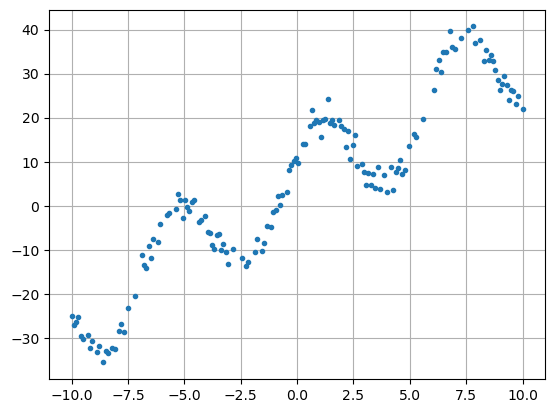

In [10]:
plt.plot(x_train, y_train, '.')

plt.grid()
plt.show()

In [11]:
def map_feature(x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

In [12]:
X_train = map_feature(x_train)
X_test = map_feature(x_test)

w_hat = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
w_hat

array([4.9244419 , 3.00200689, 9.40904576, 6.98601898])

In [16]:
sum((w-w_hat)/w)

-0.029009583604370556

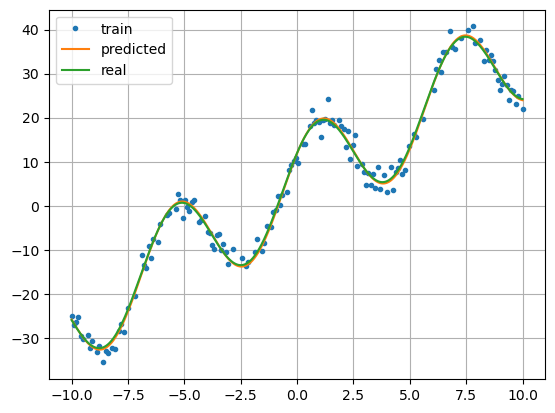

In [17]:
plt.plot(x_train, y_train, '.', label='train')
x = np.linspace(-10, 10, 2000)
plt.plot(x, map_feature(x)@w_hat, label='predicted')

x = np.linspace(-10, 10, 2000)
plt.plot(x, map_feature(x)@w, label='real')

plt.legend(loc='best')
plt.grid()
plt.show()

Solution two:
    
Look up for the solution $\hat{f}$ in the space of $\mathcal{F}$. Function $\hat{f}$ is described by it's own parameters $\hat{w}.$

How to find $\hat{w}?$

1. Gradient descent:

$$w_{t+1} = w_t - \alpha_t \frac{\partial L}{\partial w}(w_t)$$

2. Neuton-Raphson:

$$w_{t+1} = w_t - \alpha_t \left ( \frac{\partial^2 L}{\partial w \partial w^T}(w_t)\right )^{-1} \frac{\partial L}{\partial w}(w_t)$$

3. Neuton-Gauss:

$$w_{t+1} = w_t - \alpha_t (F_t^T F_t)^{-1}F_t^T(f_t - y), F_t = ||\frac{\partial f}{\partial w^j}(x_i, w_t)||_{i,j}, f_t = ||f(x_i, w_t)||$$


In [18]:
def f(w, x):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return X@w

def d_f_d_w(w, x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

def d_L_d_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return 2*X.T@X@w-2*X.T@y

def d_2_L_d_2_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return 2*X.T@X

In [19]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - 0.0001*d_L_d_w(w_hat, x_train, y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 323 ms, sys: 9.32 ms, total: 332 ms
Wall time: 382 ms


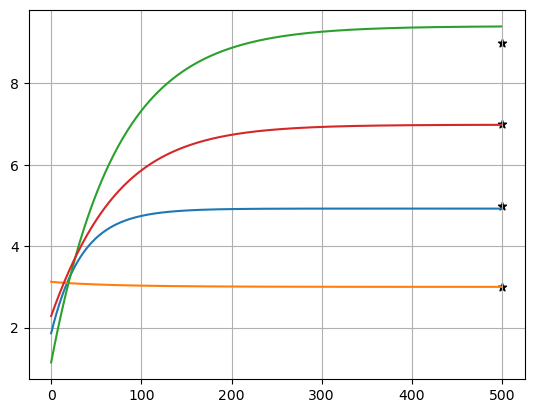

In [20]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()

In [21]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - np.linalg.inv(d_2_L_d_2_w(w_hat, x_train, y_train))@d_L_d_w(w_hat, x_train, y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 2.45 s, sys: 430 ms, total: 2.88 s
Wall time: 737 ms


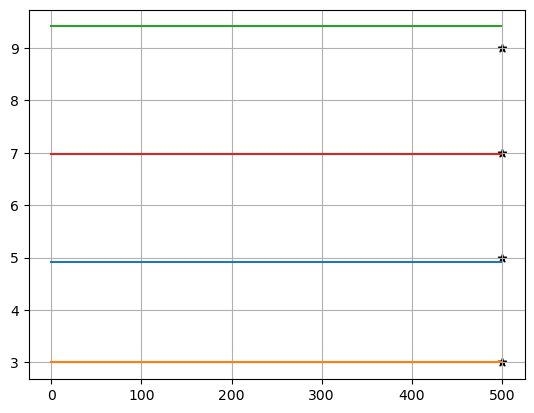

In [22]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()

In [23]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    F_t = d_f_d_w(w_hat, x_train)
    w_hat = w_hat-np.linalg.inv(F_t.T@F_t)@F_t.T@(f(w_hat, x_train)- y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 2.21 s, sys: 398 ms, total: 2.61 s
Wall time: 673 ms


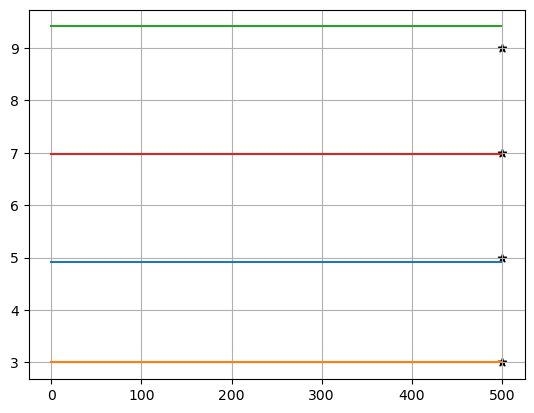

In [24]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()